In [2]:
# %pip install -q matplotlib 
# %pip install -q seaborn
# %pip install -q pandas
# %pip install -q numpy

In [2]:
import matplotlib.pyplot as plt 
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
import os 
import re
from labellines import labelLines

In [3]:
ior_results_dir = "ior_results"

# for each csv in each dir
# take the highest bandwidth row
full = pd.DataFrame()
for dir in os.listdir(ior_results_dir):
    dir_path = os.path.join(ior_results_dir, dir)
    for file_name in os.listdir(dir_path):
        if file_name.endswith('.csv'): 
            file = os.path.join(dir_path, file_name)
            tmp = pd.read_csv(file)
            tmp = (tmp.iloc[tmp.idxmax(numeric_only=True)['bw(MiB/s)']].to_frame().T)
            tmp['fromCSV'] = file_name
            tmp['segments'] = re.search(r'.*_seg-(\d+)_.*', file).group(1)
            full = pd.concat([full,tmp], ignore_index=True)

In [4]:

full['nnodes'] = full['fromCSV'].str.extract(r'.*_n-(\d+)_.*')
full['nnodes'] = full['nnodes'].astype(int)
full['segments'] = full['segments'].astype(int)
full['block(KiB)'] = full['block(KiB)'].astype(int)
full['xfer(KiB)'] = full['xfer(KiB)'].astype(int)
full['bw(GiB/s)'] =  full['bw(MiB/s)']/1024
# number of tasks, per node  as a column
full['tasks_per_node'] = full['numTasks']/full['nnodes']

# IOR_TX_SIZES=("16K" "1M" "2M" "16M")
xfer_map = {
    16:'16K',
    1024:'1M',
    2048:'2M',
    16384:'4M'
}
xfer_order = ["16K", "1M", "2M", "4M"]
full['xfer_str'] = full['xfer(KiB)'].map(xfer_map)


full.to_csv('ior_results.csv')
print(full.columns)
# print(df.to_string())
s1 = full[full['segments']==1]

frequency_table = pd.crosstab(s1['fromCSV'], 'Count')
print(frequency_table[frequency_table['Count']>1])

readme_images = []
sns.set_style("whitegrid")

Index(['access', 'bw(MiB/s)', 'IOPS', 'Latency', 'block(KiB)', 'xfer(KiB)',
       'open(s)', 'wr/rd(s)', 'close(s)', 'total(s)', 'numTasks', 'iter',
       'fromCSV', 'segments', 'nnodes', 'bw(GiB/s)', 'tasks_per_node',
       'xfer_str'],
      dtype='object')
Empty DataFrame
Columns: [Count]
Index: []


# Bandwidth Plots

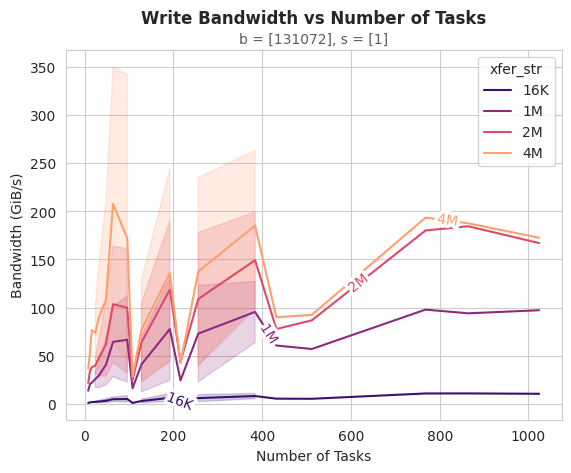

<Figure size 640x480 with 0 Axes>

In [5]:
x = "numTasks"
y = "bw(GiB/s)"
hue = "xfer_str"
hue_order = xfer_order
df = s1
palette = sns.color_palette("magma", len(df[hue].unique()))

ax = sns.lineplot(
                data=df,
                x=x,
                y=y,
                hue=hue,
                hue_order=hue_order,
                palette=palette
            )

lines=ax.get_lines()
lines = [l for l in lines if len(l.get_ydata())>0]
handles, labels = ax.get_legend_handles_labels()
labels = [label for label in labels if label in hue_order ]
for line, label in zip(lines, labels):
    line.set_label(label)
labelLines(lines)

ax.set_xlabel("Number of Tasks")
ax.set_ylabel("Bandwidth (GiB/s)")
ax.set_title("Write Bandwidth vs Number of Tasks", weight="bold", x=0.5, y=1.05)
ax.text(x=0.5, y=1.01, 
                    s=f"b = {s1['block(KiB)'].unique()}, s = {s1['segments'].unique()}", 
                    fontsize=10, alpha=0.75, ha='center', va='bottom', 
                    transform=ax.transAxes)

img_path = "graphs/ior_bandwidth/bw_vs_nt_hue-xfer.svg"
plt.savefig(img_path, bbox_inches="tight")
readme_images.append(img_path)
plt.show()
plt.clf() 

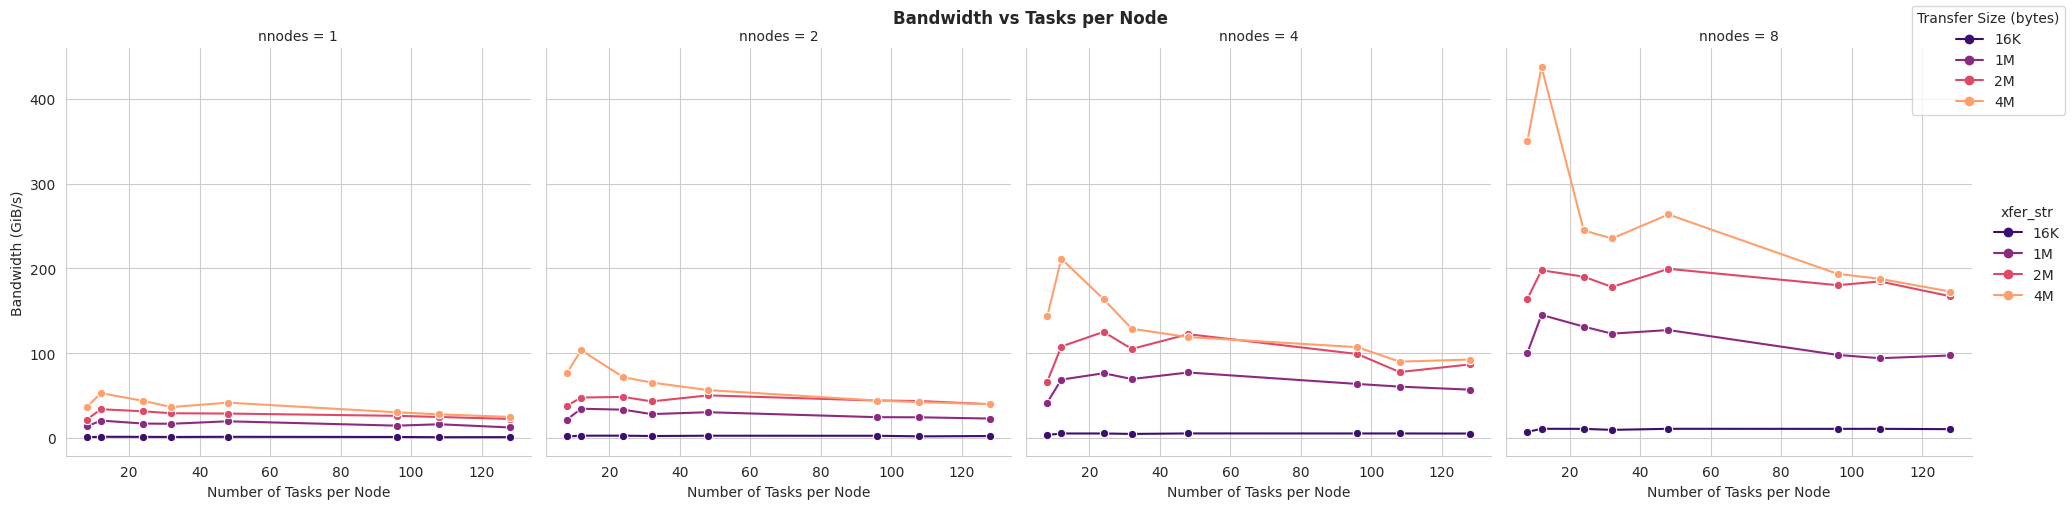

<Figure size 640x480 with 0 Axes>

In [11]:
x = "tasks_per_node"
y = "bw(GiB/s)"
hue = "xfer_str"
hue_order = xfer_order
df = s1
palette = sns.color_palette("magma", len(df[hue].unique()))

g = sns.relplot(data=df,
                kind="line",
                x=x,
                y=y,
                hue=hue,
                hue_order=hue_order,
                col='nnodes',
                palette=palette,
                marker='o'
                )
g.set_xlabels("Number of Tasks per Node")
g.set_ylabels("Bandwidth (GiB/s)")
g.figure.suptitle("Bandwidth vs Tasks per Node",  weight="bold", x = 0.5, y=1.01)
plt.gcf().legend(title="Transfer Size (bytes)")

img_path = ("graphs/ior_bandwidth/ior_bw_vs_nt_hue-xfer_col-n.svg")
plt.savefig(img_path, bbox_inches="tight")
readme_images.append(img_path)
plt.show()
plt.clf()

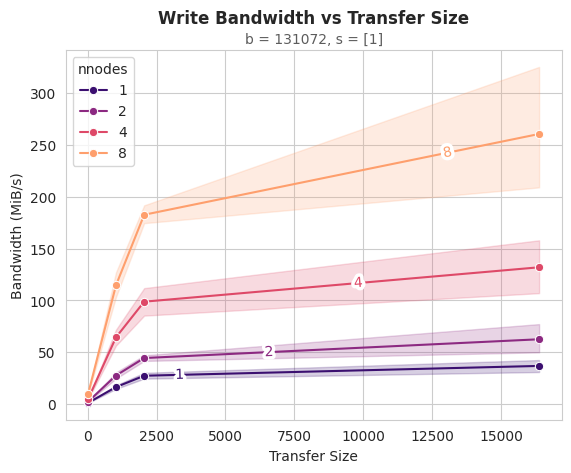

<Figure size 640x480 with 0 Axes>

In [8]:
x = "xfer(KiB)"
y = "bw(GiB/s)"
hue = "nnodes"
hue_order = 'nnodes'
df = s1
palette = sns.color_palette("magma", len(df[hue].unique()))

ax = sns.lineplot(data=df, x=x, y=y, hue="nnodes",
                 marker='o', palette=palette
            )
# ax.set_xticks(subdf["job options.numjobs"].unique())
lines=ax.get_lines()
lines = [l for l in lines if len(l.get_ydata())>0]
handles, labels = ax.get_legend_handles_labels()
labels = [label for label in labels if label in str(s1['nnodes'].unique().tolist()) ]
for line, label in zip(lines, labels):
                line.set_label(label)
labelLines(lines)
ax.set_xlabel("Transfer Size")
ax.set_ylabel("Bandwidth (MiB/s)")
ax.set_title("Write Bandwidth vs Transfer Size", weight="bold", x=0.5, y=1.05)
ax.text(x=0.5, y=1.01, 
                s=f"b = {s1['block(KiB)'].unique()[0]}, s = {s1['segments'].unique()}", 
                fontsize=10, alpha=0.75, ha='center', va='bottom', 
                transform=ax.transAxes)
plt.savefig("graphs/ior_bandwidth/bw_vs_xfer_hue-n.svg", bbox_inches='tight')
plt.show()
plt.clf() 

# IOPS Plots

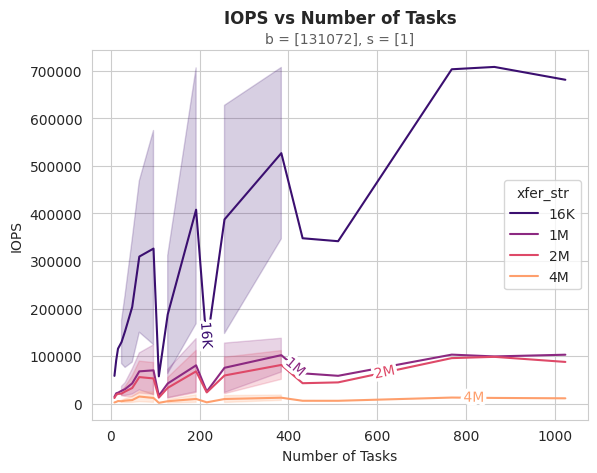

<Figure size 640x480 with 0 Axes>

In [9]:
x = "numTasks"
y = "IOPS"
hue = "xfer_str"
hue_order = xfer_order
df = s1
palette = sns.color_palette("magma", len(df[hue].unique()))

ax = sns.lineplot(data=df, x=x, y=y,
                hue=hue, hue_order=hue_order,
                palette=palette
            )

lines=ax.get_lines()
lines = [l for l in lines if len(l.get_ydata())>0]
handles, labels = ax.get_legend_handles_labels()
labels = [label for label in labels if label in hue_order ]
for line, label in zip(lines, labels):
    line.set_label(label)
labelLines(lines)

ax.set_xlabel("Number of Tasks")
ax.set_ylabel("IOPS")
ax.set_title("IOPS vs Number of Tasks", weight="bold", x=0.5, y=1.05)
ax.text(x=0.5, y=1.01, 
                    s=f"b = {s1['block(KiB)'].unique()}, s = {s1['segments'].unique()}", 
                    fontsize=10, alpha=0.75, ha='center', va='bottom', 
                    transform=ax.transAxes)

img_path = "graphs/ior_iops/ior_iops_vs_nt_hue-xfer.svg"
plt.savefig(img_path, bbox_inches="tight")
readme_images.append(img_path)
plt.show()
plt.clf() 


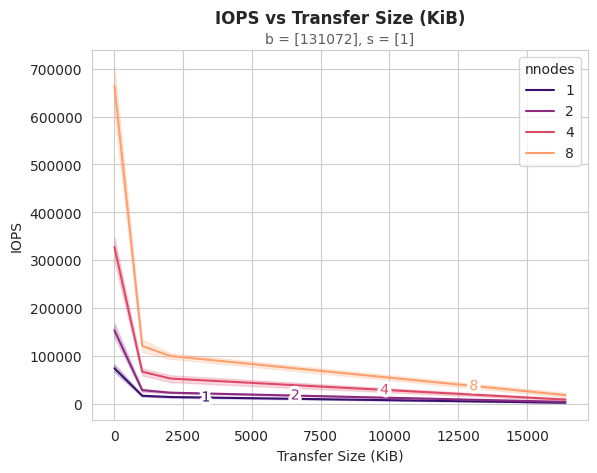

<Figure size 640x480 with 0 Axes>

In [10]:
x = "xfer(KiB)"
y = "IOPS"
hue = "nnodes"
hue_order = df['nnodes'].unique().tolist()
hue_order.sort()
df = s1
palette = sns.color_palette("magma", len(df[hue].unique()))

ax = sns.lineplot(data=df, x=x, y=y,
                hue=hue, hue_order=hue_order,
                palette=palette
            )

lines=ax.get_lines()
lines = [l for l in lines if len(l.get_ydata())>0]
handles, labels = ax.get_legend_handles_labels()
labels = [label for label in labels if label in str(hue_order) ]
for line, label in zip(lines, labels):
    line.set_label(label)
labelLines(lines)

ax.set_xlabel("Transfer Size (KiB)")
ax.set_ylabel("IOPS")
ax.set_title("IOPS vs Transfer Size (KiB)", weight="bold", x=0.5, y=1.05)
ax.text(x=0.5, y=1.01, 
                    s=f"b = {s1['block(KiB)'].unique()}, s = {s1['segments'].unique()}", 
                    fontsize=10, alpha=0.75, ha='center', va='bottom', 
                    transform=ax.transAxes)

img_path = "graphs/ior_iops/ior_iops_vs_xfer_hue-n.svg"
plt.savefig(img_path, bbox_inches="tight")
readme_images.append(img_path)
plt.show()
plt.clf() 

# Latency Plots

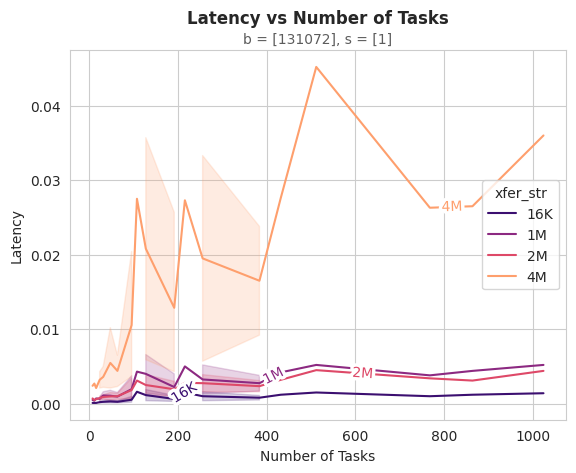

<Figure size 640x480 with 0 Axes>

In [11]:
x = "numTasks"
y = "Latency"
hue = "xfer_str"
hue_order = xfer_order
df = s1
palette = sns.color_palette("magma", len(df[hue].unique()))

ax = sns.lineplot(data=df, x=x, y=y,
                hue=hue, hue_order=hue_order,
                palette=palette
            )

lines=ax.get_lines()
lines = [l for l in lines if len(l.get_ydata())>0]
handles, labels = ax.get_legend_handles_labels()
labels = [label for label in labels if label in hue_order ]
for line, label in zip(lines, labels):
    line.set_label(label)
labelLines(lines)

ax.set_xlabel("Number of Tasks")
ax.set_ylabel("Latency")
ax.set_title("Latency vs Number of Tasks", weight="bold", x=0.5, y=1.05)
ax.text(x=0.5, y=1.01, 
                    s=f"b = {s1['block(KiB)'].unique()}, s = {s1['segments'].unique()}", 
                    fontsize=10, alpha=0.75, ha='center', va='bottom', 
                    transform=ax.transAxes)

img_path = "graphs/ior_latency/ior_lat_vs_nt_hue-xfer.svg"
plt.savefig(img_path, bbox_inches="tight")
readme_images.append(img_path)
plt.show()
plt.clf() 


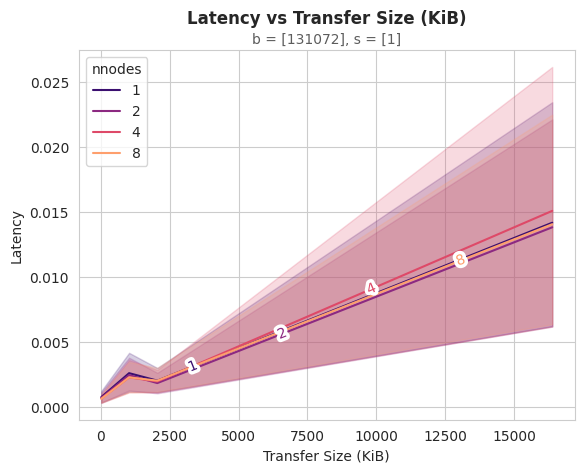

<Figure size 640x480 with 0 Axes>

In [12]:
x = "xfer(KiB)"
y = "Latency"
hue = "nnodes"
hue_order = df['nnodes'].unique().tolist()
hue_order.sort()
df = s1
palette = sns.color_palette("magma", len(df[hue].unique()))

ax = sns.lineplot(data=df, x=x, y=y,
                hue=hue, hue_order=hue_order,
                palette=palette
            )

lines=ax.get_lines()
lines = [l for l in lines if len(l.get_ydata())>0]
handles, labels = ax.get_legend_handles_labels()
labels = [label for label in labels if label in str(hue_order) ]
for line, label in zip(lines, labels):
    line.set_label(label)
labelLines(lines)

ax.set_xlabel("Transfer Size (KiB)")
ax.set_ylabel("Latency")
ax.set_title("Latency vs Transfer Size (KiB)", weight="bold", x=0.5, y=1.05)
ax.text(x=0.5, y=1.01, 
                    s=f"b = {s1['block(KiB)'].unique()}, s = {s1['segments'].unique()}", 
                    fontsize=10, alpha=0.75, ha='center', va='bottom', 
                    transform=ax.transAxes)

img_path = "graphs/ior_latency/ior_lat_vs_xfer_hue-n.svg"
plt.savefig(img_path, bbox_inches="tight")
readme_images.append(img_path)
plt.show()
plt.clf() 

In [13]:
# palette = sns.color_palette("magma", len(df["iter"].unique()))
# ax = sns.lineplot(
#                 data=df,
#                 x="xfer(KiB)",
#                 y="bw(MiB/s)",
#                 hue="iter",
#                 # style="rand_seq_type", dashes=dashes,
#                 # marker='o',
#                 # hue_order=hue_order,
#                 # order=bs_order,
#                 # palette=palette
#             )
# ax.set_xlabel("Number of Tasks")
# ax.set_ylabel("Bandwidth (MiB/s)")
# ax.set_title("Bandwidth vs Number of Tasks (all iter)", weight="bold", x=0.5, y=1.05)
# plt.show()
# plt.clf() 

In [14]:
copy_paste_str = "## Images from plot_ior.ipynb:\n"
for img_path in readme_images:
    copy_paste_str += f'![{img_path}]({img_path})\n'
print(copy_paste_str)

## Images from plot_ior.ipynb:
![graphs/ior_bandwidth/bw_vs_nt_hue-xfer.svg](graphs/ior_bandwidth/bw_vs_nt_hue-xfer.svg)
![graphs/ior_bandwidth/ior_bw_vs_nt_hue-xfer_col-n.svg](graphs/ior_bandwidth/ior_bw_vs_nt_hue-xfer_col-n.svg)
![graphs/ior_iops/ior_iops_vs_nt_hue-xfer.svg](graphs/ior_iops/ior_iops_vs_nt_hue-xfer.svg)
![graphs/ior_iops/ior_iops_vs_xfer_hue-n.svg](graphs/ior_iops/ior_iops_vs_xfer_hue-n.svg)
![graphs/ior_latency/ior_lat_vs_nt_hue-xfer.svg](graphs/ior_latency/ior_lat_vs_nt_hue-xfer.svg)
![graphs/ior_latency/ior_lat_vs_xfer_hue-n.svg](graphs/ior_latency/ior_lat_vs_xfer_hue-n.svg)



In [2]:

lcm = 24
for i in range(10):
    print(lcm*i)

0
24
48
72
96
120
144
168
192
216
